# Jupiter Tisserand parameters

Jovian Tisserand parameter T<sub>J</sub> for asteroids (black points) and comets (white circles). The vertical
dashed line indicates the Sun – Jupiter distance, ajup = 5.20 au; the curved solid line is Tjup,max.

In [37]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

# astroquery

from astroquery.mpc import MPC

# suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)
warnings.filterwarnings('ignore',category=RuntimeWarning, append=True)

## Standard Plot Format

Setup the standard plotting format and make the plot.  

In [38]:
# graphic aspect ratio = width/height

aspect = 16.0/9.0 # wide-screen

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 0.85

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 12
labelFontSize = 10
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)
    
# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## Asteroid data

Asteroid data are in a CSV file pre-selected from the MPC database for all asteroids in the Main Belt
plus the Hungarias, Hildas, and Jupiter Trojans brighter than H=16.  This is faster
than reading all roughly 1.3 million entries in the full MPCORB database.

In [39]:
# Main Belt

mbHmax = 14.0

result = MPC.query_objects('asteroid',
                           orbit_type=0,absolute_magnitude_max=mbHmax,
                           return_fields='semimajor_axis,eccentricity,inclination')

aMB = np.array([float(d.get('semimajor_axis',None)) for d in result])
eMB = np.array([float(d.get('eccentricity',None)) for d in result])
iMB = np.radians(np.array([float(d.get('inclination',None)) for d in result]))

print(f"Retrieved {len(aMB)} main-belt astroids")

# Jupiter trojans

Hmax = 16.0
result = MPC.query_objects('asteroid',
                           orbit_type=9,
                           absolute_magnitude_max=Hmax,
                           return_fields='semimajor_axis,eccentricity,inclination')

aT = np.array([float(d.get('semimajor_axis',None)) for d in result])
eT = np.array([float(d.get('eccentricity',None)) for d in result])
iT = np.radians(np.array([float(d.get('inclination',None)) for d in result]))

print(f"Retrieved {len(aJT)} Jupiter trojans")

# Hildas

result = MPC.query_objects('asteroid',
                           orbit_type=8,
                           absolute_magnitude_max=Hmax,
                           return_fields='semimajor_axis,eccentricity,inclination')

aH = np.array([float(d.get('semimajor_axis',None)) for d in result])
eH = np.array([float(d.get('eccentricity',None)) for d in result])
iH = np.radians(np.array([float(d.get('inclination',None)) for d in result]))

print(f"Retrieved {len(aH)} Hildas")

# Phocaeas

result = MPC.query_objects('asteroid',
                           orbit_type=7,
                           absolute_magnitude_max=Hmax,
                           return_fields='semimajor_axis,eccentricity,inclination')

aPho = np.array([float(d.get('semimajor_axis',None)) for d in result])
ePho = np.array([float(d.get('eccentricity',None)) for d in result])
iPho = np.radians(np.array([float(d.get('inclination',None)) for d in result]))

print(f"Retrieved {len(aPho)} Phocaeas")


# Hungarias

result = MPC.query_objects('asteroid',
                           orbit_type=6,
                           absolute_magnitude_max=Hmax,
                           return_fields='semimajor_axis,eccentricity,inclination')

aHun = np.array([float(d.get('semimajor_axis',None)) for d in result])
eHun = np.array([float(d.get('eccentricity',None)) for d in result])
iHun = np.radians(np.array([float(d.get('inclination',None)) for d in result]))

print(f"Retrieved {len(aHun)} Hungarias")

aMin = 1.8
aMax = 7.0 

Retrieved 16384 main-belt astroids
Retrieved 15410 Jupiter trojans
Retrieved 2962 Hildas
Retrieved 2083 Phocaeas
Retrieved 717 Hungarias


## Comets

Restrict attention to semimajor axes betwen aMin and aMax

In [40]:
result = MPC.query_objects('comet',
                           semimajor_axis_min=aMin,
                           semimajor_axis_max=aMax,
                           return_fields='semimajor_axis,eccentricity,inclination')

aC = np.array([float(d.get('semimajor_axis',None)) for d in result])
eC = np.array([float(d.get('eccentricity',None)) for d in result])
iC = np.radians(np.array([float(d.get('inclination',None)) for d in result]))

print(f"Retrieved {len(aC)} Comets")

Retrieved 3070 Comets


## Jupiter orbital data

Data from the NASA/JPL Solar System Dynamics database

In [41]:
aJup = 5.20288700 # au
eJup = 0.04838624
PJup = 4332.820129/365.25 # years
iJup = 1.30439695

## Compute the Jupiter Tisserand parameter

Compute 
\begin{equation}
   T_J = \frac{a_J}{a} + 2\left[\frac{a}{a_J}(1-e^2)\right]^{1/2}\cos i
\end{equation}
for all of the asteroids.

Also compute the maximum Jupiter Tisserand parameter
\begin{equation}
  T_{J,max} = \frac{a_J}{a} + 2\left(\frac{a}{a_J}\right)^{1/2}
\end{equation}

In [42]:
# asteroids

TJmb = (aJup/aMB) + 2.0*np.sqrt((aMB/aJup)*(1-eMB*eMB))*np.cos(iMB)
TJhilda = (aJup/aH) + 2.0*np.sqrt((aH/aJup)*(1-eH*eH))*np.cos(iH)
TJtrojan = (aJup/aT) + 2.0*np.sqrt((aT/aJup)*(1-eT*eT))*np.cos(iT)
TJhun = (aJup/aHun) + 2.0*np.sqrt((aHun/aJup)*(1-eHun*eHun))*np.cos(iHun)
TJpho = (aJup/aPho) + 2.0*np.sqrt((aPho/aJup)*(1-ePho*ePho))*np.cos(iPho)

# comets

TJc = (aJup/aC) + 2.0*np.sqrt((aC/aJup)*(1-eC*eC))*np.cos(iC) 

# T_J,max line

aTJ = np.linspace(aMin,aMax,101)
TJmax = (aJup/aTJ) + 2.0*np.sqrt(aTJ/aJup)

# axis limits

minTJ = 1.8
maxTJ = 4

# semimajor axis of a p:q resonance for perturber with semimajor axis a_p

def a_pq(a_p,p,q):
    return a_p*(p/q)**(2./3.)


## Make the plot

Plot asteroids as semi-transparent black dots since there are so many of them.  This will make a "point cloud"
plot.

Overlay the comets as white filled circles with a thin black border.

The T$_{J,max}$ line is plotted as a thick black line.  Indicate the location of Jupiter's orbit with
a thin, black vertical dashed line.  Uncomment other lines of code to show the locations of the main 
Jupiter mean-motion resonances.

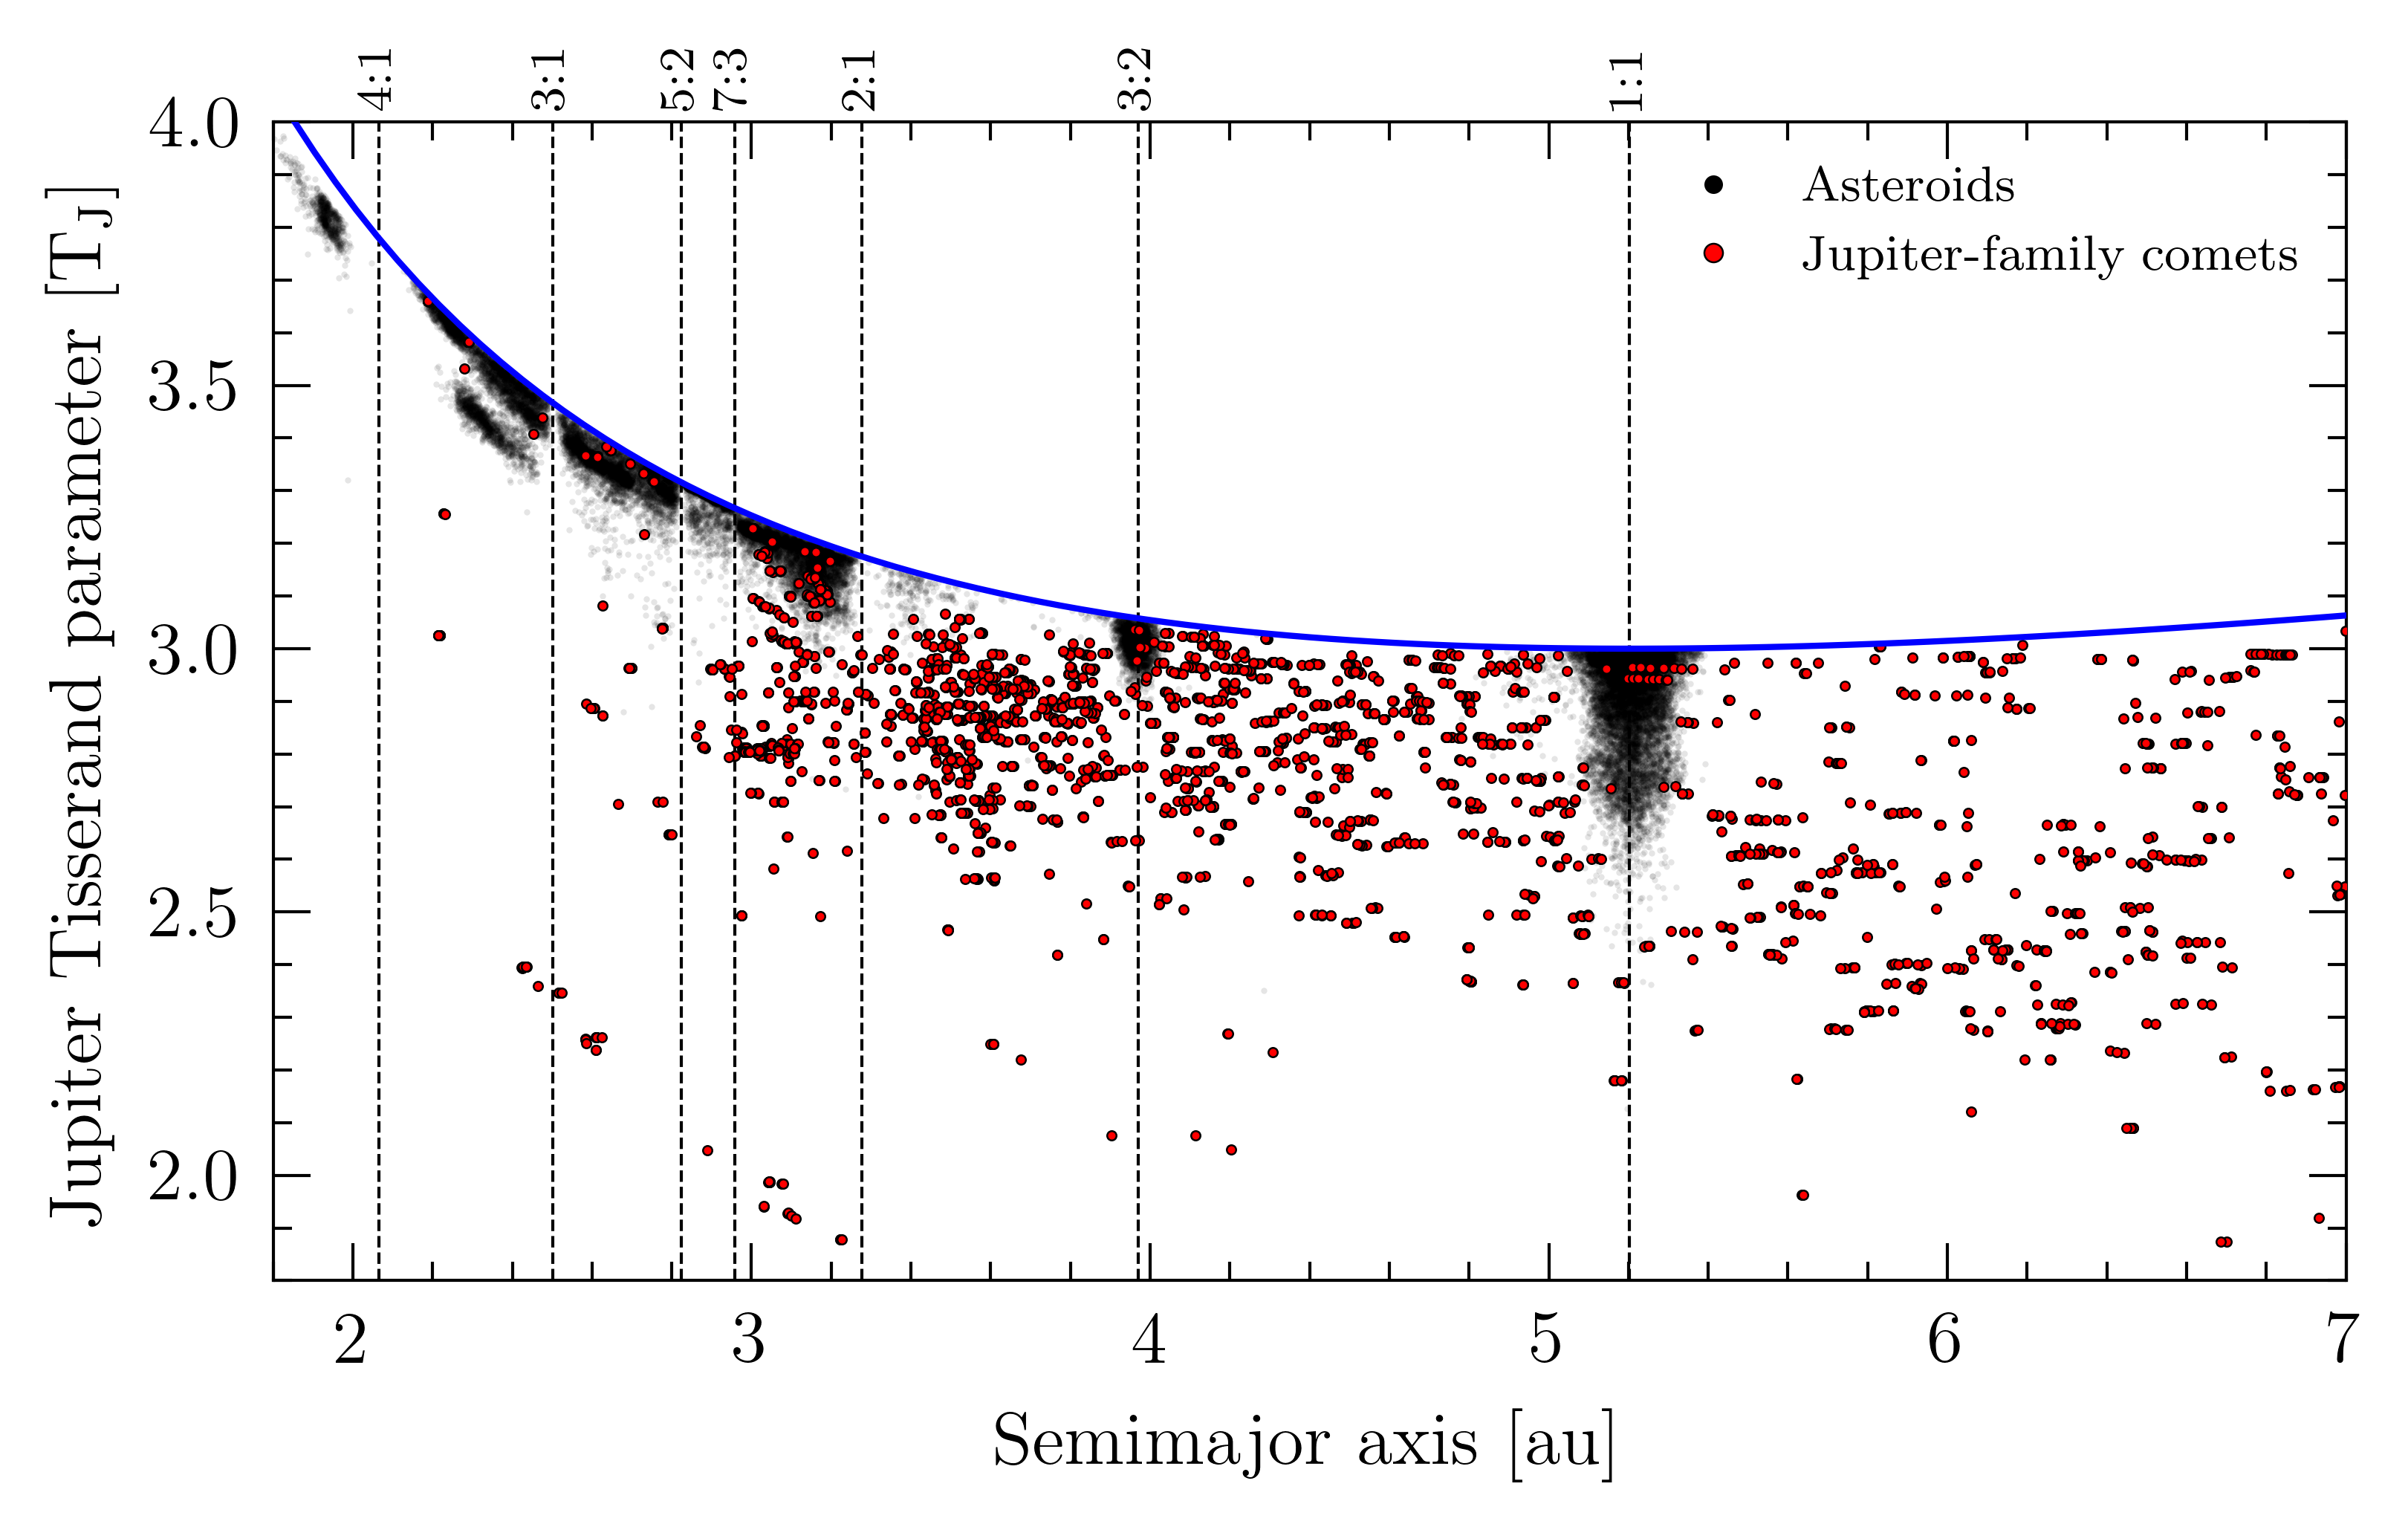

In [43]:
plotFile = "Jupiter_Tisserand.png"
showKey = True

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)

ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(aMin,aMax)
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_xlabel(r'Semimajor axis [au]',fontsize=axisFontSize)

ax.set_ylim(minTJ,maxTJ)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_ylabel(r'Jupiter Tisserand parameter [T$_{\rm J}$]',fontsize=axisFontSize)

# Asteroids as small back dots, comets as circles filled with light gray

ax.plot(aMB,TJmb,'o',ms=1,mfc='black',mec=None,mew=0,alpha=0.1,zorder=8,label="Asteroids")
ax.plot(aH,TJhilda,'o',ms=1,mfc='black',mec=None,mew=0,alpha=0.1,zorder=8)
ax.plot(aT,TJtrojan,'o',ms=1,mfc='black',mec=None,mew=0,alpha=0.1,zorder=8)
ax.plot(aHun,TJhun,'o',ms=1,mfc='black',mec=None,mew=0,alpha=0.1,zorder=8)
ax.plot(aPho,TJpho,'o',ms=1,mfc='black',mec=None,mew=0,alpha=0.1,zorder=8)

ax.plot(aC,TJc,'o',ms=1.5,mfc='red',mec='black',mew=0.3,zorder=8,label="Jupiter-family comets")

# T_jup,max line

ax.plot(aTJ,TJmax,'-',color='blue',lw=1,zorder=10)

if showKey:
    leg = ax.legend(loc="upper right",frameon=False,prop={'size':8})
    for handle in leg.legend_handles:
        handle.set_markersize(3)
        handle.set_alpha(1.0)

# resonances (Trojans, Hildas, and the main Kirkwood gaps and main belt inner/outer edges at the 4:1 and 2:1)

a32 = a_pq(aJup,2,3)
a41 = a_pq(aJup,1,4)
a31 = a_pq(aJup,1,3)
a21 = a_pq(aJup,1,2)
a52 = a_pq(aJup,2,5)
a73 = a_pq(aJup,3,7)

ax.vlines([a32,a21,a31,a41,a52,a73,aJup],minTJ,maxTJ,ls=['--'],colors=['black'],lw=0.5,zorder=5)
ax.text(aJup,maxTJ+0.02,'1:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a32,maxTJ+0.02,'3:2',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a41,maxTJ+0.02,'4:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a31,maxTJ+0.02,'3:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a21,maxTJ+0.02,'2:1',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a52,maxTJ+0.02,'5:2',ha='center',va='bottom',fontsize=8,color='black',rotation=90)
ax.text(a73,maxTJ+0.02,'7:3',ha='center',va='bottom',fontsize=8,color='black',rotation=90)

# hardcopy 

plt.savefig(plotFile,bbox_inches='tight',facecolor='white')

plt.show()